## Lab04: Vulnerability Risk Prediction
___

In many situations during our personal or professional lives, we want to predict some important number given our knowledge about a subject. Some natural examples of this are:

* Given the number of rooms a house has and the neighborhood its located in, can we predict how much it will cost?
* Given how similar a product is to its counterparts, how much should it cost (cars, computers, smartphones)?
* How much will my crops grow given the amount of rain we had?
* Can I guess future trends in the stock market for a particular equity, given the financial reports released publicaly by its company?
* Can I predict a severity score for a vulnerability, given its characteristics?

Regression analysis is a set of statistical techniques that tackles this problem. In essence, regression models help us predict a value metric we want to know based on a set of features. 


![Regression exemple](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/1200px-Linear_least_squares_example2.svg.png)


___

## Agenda

- Dataset
  - visualizing data

- Linear Regression
  - K-fold Cross-Validation

  - Coefficient of Determination

- Polynomial Regression

- Lab: Predicting Vulnerability Score
___

## Dataset

For this class, we will the Boston housing dataset, a dataset containing features for several houses in Boston and their prices. We will use this dataset to predict the price of a house, given its features.


### Loading dataset

The dataset is provided with the scikit-learn package.

To make things simpler, we will consider only three features of this dataset and the value we want to predict:

**CRIM:** Per capita crime rate by town (neighborhood)

**NOX:** A measure of pollution in the house region, nitric oxide concentration (parts per 10 million)

**RM:** Average number of rooms per house

**MEDV:** The value we want to predict, the price of the house in \$1000 USD

For a full description of the boston dataset, check [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)


In [ ]:
import numpy as np
from sklearn.datasets import load_boston
import pandas as pd

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston = boston[["CRIM", "NOX", "RM"]]
boston["MEDV"] = boston_dataset.target
print("The size of our dataset (lines, columns):", boston.shape)
boston.head()

### Visualizing data

Before we start our predictions, let's take a look at our data. When working with Machine Learning, it's always important to understand the data we are working with.

We will use [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) for our visualizations. First, let's take a look at the distribution of house prices in our dataset.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=50)
plt.show()

print("Min:", min(boston['MEDV']))
print("Max:", max(boston['MEDV']))
print("Mean:", np.mean(boston['MEDV']))
print("Median:", np.median(boston['MEDV']))
print("Mode:", max(set(boston['MEDV']), key=list(boston["MEDV"]).count))
print("Skewness:", stats.skew(boston['MEDV']))

As we can see, the house prices vary from \$5,000 to \$50,000 dollars. The houses have mean and median prices around \$20,000 dollars, where we observe the largest peak in our distribution. However, we also note a small peak at \$50,000 dollars, which turns out to be our mode. This likely means that an average house in Boston costs around \$20,000 dollars, while a high-end or large house costs around \$50,000 dollars.

Now let's look at our features, namely, let's see how our features influence the price of the house:

In [ ]:
plt.figure(figsize=(20, 5))

features = ["CRIM", "NOX", "RM"]
target = boston["MEDV"]

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

We see three plots that correlate the price of the house with each of our features. These are the trends we observe:

- **CRIM:** Houses in regions with lower crime rates are more expensive
- **NOX:** Houses in less poluted regions are more expensive
- **RM:** Houses with more rooms are more expensive

Note how this conforms with our expectation. Houses in regions with less polution and crime are more desirable, thus, more expensive. Similarly, houses with more rooms are larger, thus, more expensive.

Now, let's see if our models can capture these relationships.

___

## Linear Regression

Linear regression models try to fit a linear function (i.e. a line) to predict the desired outcome.

One of the most popular and simple examples of Linear Regression is the [**Least Squares Linear Regression**](https://medium.com/swlh/linear-regression-c03718bfe9a3). This type of model looks for the line that minimizes the sum of squared distances of the training points to the line. i.e.

![Residuals.png](https://miro.medium.com/max/346/1*SfZpl4HO9BVcze999KVIYA.png)

We have the objects in the training set as blue dots and the distances to the fit line in red. The goal of the model is to find the line that minimizes the square of this distance.



We will use the SciKit Learn framework's Ordinary Least Squares implementation. Let's first split our dataset into training and test.


In [ ]:
from sklearn import model_selection

# It is common practice in machine learning to call data X and labels y
X_train, X_test, y_train, y_test = model_selection.train_test_split(
      boston[["CRIM", "NOX", "RM"]].values,
      boston[["MEDV"]].values,
      test_size=0.2
    )

print("Training and test sizes:", X_train.shape, X_test.shape)

Now let's train our model:

In [ ]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg

Now, lets see how it performs in the test set. Let's plot some of the predicted values and the true values.

In [ ]:
y_preds  = linear_reg.predict(X_test)

point_indices = range(20)
plt.plot(point_indices, y_preds[-20:], label="prediction")
plt.plot(point_indices, y_test[-20:], label="ground truth")
plt.legend()

We can see that the model is not perfect, it does not match exactly the house price, but it does capture the price trends pretty well **given these training and test sets.**

### K-fold Cross-Validation

So far, we have split our datasets into training and test sets and used that to train and test our models. However, a natural question we may ask is: how can we be sure that our model didn't just get "lucky" to get an easy test set split?

To make sure we avoid this type of bias in our model, we use **K-fold cross-validation**. The idea is simple: Instead of separating the data into training set and test sets once, we will do that $k$ times:

1. Split data into training and test sets randomly
2. train the model using training set
3. test the model using the test set
4. repeat $k$ times

However, instead of just randomly sampling training and tests sets every time, we split the dataset once into k-folds (hence the name, k-fold) and just change which folds we use for training and testing. Visually:

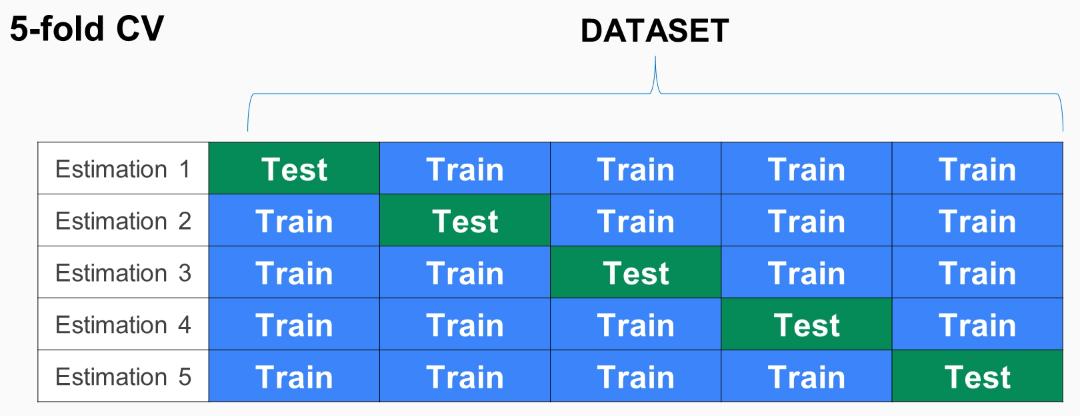

This not only makes the process easier but also ensures we always have unique test sets, making the process more robust. You can read more about k-fold cross-validation [here](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6).

So, let's use cross-validation to see if our model is robust. It is a common practice to use 5-fold cross-validation, so we'll use that. Let's separate our data into folds and take a peek at the folds

In [ ]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

X, y = boston[["CRIM", "NOX", "RM"]].values, boston[["MEDV"]].values

print("Total samples:", X.shape[0])
for train_indices, test_indices in kf.split(X):
  print("Split:", train_indices.shape, test_indices.shape, test_indices[:5])


Notice that the folds are always (roughly) the same size and the test points are always different. Let's now use this to train and evaluate our model.

We want to see if our model is robust, i.e., if given different data points it will achieve similar performance. To make this easy to compare, we will use a common metric in regression called the Mean-squared error (MSE). MSE means the mean squared distance between the model's predictions and the ground-truth. I.e. the mean of the squares of the error lines:

![Residuals.png](https://jermwatt.github.io/machine_learning_refined/mlrefined_images/superlearn_images/Least_Squares.png)

In [ ]:
from sklearn.metrics import mean_squared_error

linear_reg = LinearRegression()
mses = []
for train_indices, test_indices in kf.split(X):
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  linear_reg.fit(X_train, y_train)

  y_preds_train  = linear_reg.predict(X_train)
  y_preds_test  = linear_reg.predict(X_test)

  train_mse = mean_squared_error(y_preds_train, y_train)
  test_mse = mean_squared_error(y_preds_test, y_test)
  print("Training:", train_mse)
  print("Test:", test_mse, "\n")

  mses.append(test_mse)

print("Average test MSE:", np.mean(mses))

We see our model is fairly robust. It always achieves similar performance, especially in the training set, as expected. 

### Coefficient of Determination

Although we can use MSE to have a sense of our model's performance, by itself, it is not a very intuitive metric. For instance, if we simply measure MSE and get ```MSE = 30``` is that good or bad?

A more intuitive metric we can is the [**Coefficient of Determination**](https://www.youtube.com/watch?v=nk2CQITm_eo&feature=share), often called the R².

The computation of R² is based on the concept of variation, which measures an average distance between data points and a baseline value, usually the mean of the data. R² produces a quality metric for our model by comparing the variation around the mean of the data to the variation around the model:

$$R^2 = \frac{Var(mean) - Var(model)}{Var(mean)} =  1 - \frac{\sum_{i=1}^n (y^{truth}_i - y^{pred}_i)^2}{\sum_{i=1}^n (y^{truth}_i - \overline{y^{mean}})^2}$$

Intuitively, R² tells us **how much of the variance of the data is explained by our model**. In a simpler view, we can interpret R² as how much better our model is compared to just taking the mean of the data and using that as a prediction.


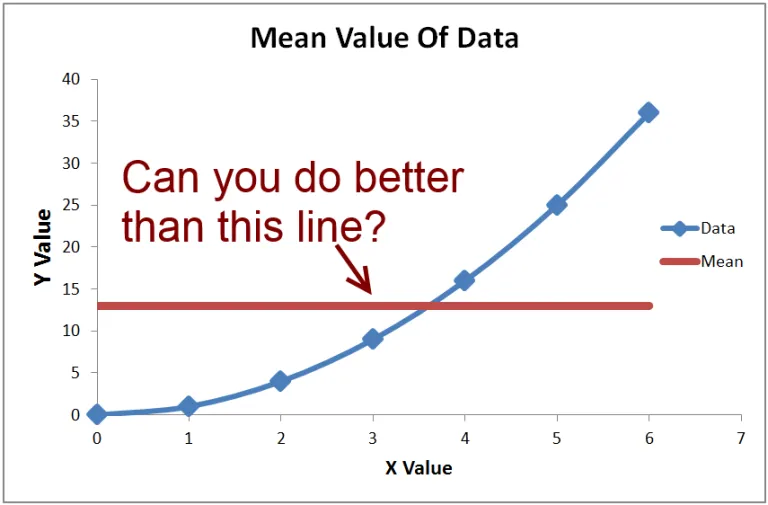

R² always gives us a value between $-\infty$ and $1$. A good model has $R^2$ near $1$. When $R^2$ is negative it means its better to predict using the average of already observed data than what the regressor is producing.

R² is a very good metric to assess the quality of our model, but in practice, we compute a slightly different version of R² called [**Adjusted R²**](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914). The difference between these two is that the adjusted R² also takes into account how many features we have in our data, reducing the R² of models with too many features. This penalizes models that use too many features, encouraging us to use simpler models. In practice, the adjusted R² is computed as:

$$R^2_{adjusted} = =  1 - \left( (1 - R^2) * \frac{n - 1}{n - k - 1} \right)$$

Where $n$ is the number of data points and $k$ is the number of features. You can read more about the R² metrics and other useful metrics [here](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914).

Let's take a look at the R² for our linear regressor.

In [ ]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y_preds, y_label, num_features):
  r2 = r2_score(y_preds, y_label)
  adjusted_r2 = (1 - (1 - r2) * ((y_label.shape[0] - 1)/(y_label.shape[0] - num_features - 1)))
  return adjusted_r2

num_features = X.shape[1]
linear_reg = LinearRegression()
r2s = []
adjusted_r2s = []
for train_indices, test_indices in kf.split(X):
  print("Fold", len(r2s))
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  linear_reg.fit(X_train, y_train)

  y_preds_train  = linear_reg.predict(X_train)
  y_preds_test  = linear_reg.predict(X_test)

  train_r2 = r2_score(y_preds_train, y_train)
  test_r2 = r2_score(y_preds_test, y_test)
  train_adjusted_r2 = adjusted_r2_score(y_preds_train, y_train, num_features)
  test_adjusted_r2 = adjusted_r2_score(y_preds_test, y_test, num_features)

  print("Training R^2:", train_r2)
  print("Training adjusted R^2:", train_adjusted_r2)
  print("Test R^2:", test_r2)
  print("Test adjusted R^2:", test_adjusted_r2, "\n")

  r2s.append(test_r2)
  adjusted_r2s.append(test_adjusted_r2)

print("Average performance")
print("Average test r2:", np.mean(r2s))
print("Average test adjusted r2:", np.mean(adjusted_r2s))

Looks like our model still has plenty of room for improvement.

## Polynomial Regression

We achieved decent performance with our linear regressor, however, the linear regressor is not a very powerful model. It always tries to fit a line to the data, but the data doesn't always follow a linear distribution. For these cases, we would like to employ a more powerful model, capable of fitting even non-linear data. 

A natural extension of linear regression is **polynomial regression**. 

The idea here is simple, instead of fitting a simple line to the data, we fit a $n$-dimensional polynomial instead. 

![polynomial regression](http://polynomialregression.drque.net/Images/Math/20140116_article_html_21092df.gif)

In order to use polynomial regression, we have to choose the degree of our polynomial, that is, the value of $n$. Basically, we have to answer the question "What shape do I expect my data to follow?". E.g., if we think the data follows a squared function, we use $n = 2$.

The quality of the final results depends on how well we choose $n$, let's take a look at a few different models in our housing dataset.




In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degrees = [1, 2, 3, 4, 5]
num_features = X_train.shape[1]
mean_r2s = []
mean_adjusted_r2s = []
for degree in degrees:
  poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  r2s = []
  adjusted_r2s = []
  for train_indices, test_indices in kf.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    poly_reg.fit(X_train, y_train)
    y_preds_test  = poly_reg.predict(X_test)

    test_r2 = r2_score(y_preds_test, y_test)
    adjusted_test_r2 = adjusted_r2_score(y_preds_test, y_test, num_features)

    r2s.append(test_r2)
    adjusted_r2s.append(adjusted_test_r2)

  mean_r2 = np.mean(r2s)
  mean_adjusted_r2 = np.mean(adjusted_r2s)
  print(f"Degree = {degree}")
  print(f"Average test r2: {mean_r2}")
  print(f"Average test adjusted r2: {mean_adjusted_r2} \n")

  mean_r2s.append(mean_r2)
  mean_adjusted_r2s.append(mean_adjusted_r2)

Let's take a better look at these results:

In [ ]:
# Compute bar positions
barWidth = 0.3
r1 = range(1, len(mean_r2s)+1)
r2 = [x + barWidth for x in r1]

# Plot bars
r2_bars = plt.bar(r1, mean_r2s, width=barWidth, label="R$^{2}$")
adjusted_r2_bars = plt.bar(r2, mean_adjusted_r2s, width=barWidth, label="Adjusted R$^{2}$")

# Add text to top of bars
for rect in r2_bars + adjusted_r2_bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' %height, ha='center', va='bottom')

# Polish axes
tick_locations = [(r1[i] + r2[i])/2 for i in range(len(r1))]
plt.xticks(tick_locations, labels=r1)
plt.xlabel("Polynomial Degree")
plt.ylabel("Score")
plt.legend()

We can see a few trends:

1. with $n = 1$ we get the same performance as linear regression. Of course! A 1-degree polynomial is the same a fitting a line to the data
2. with $n = 2$ and $n = 3$, we get much better performance, about 30% better R².
3. with $n = 4$ and $n = 5$, we see that performance becomes worse again

So, this indicates that a polynomial of degree 2 or 3 are a better fit for our data in this case

## Lab: Vulnerability Risk Prediction

Now, let's train a regression model to predict the severity of a vulnerability. For this, we will use the same CVSS data we used in the previous assignment, but this time, we will predict the severity score instead of a single severity class.

First, let's load the data: 

In [ ]:
# Download the dataset
!wget 'https://docs.google.com/uc?export=download&id=1lmyZpILl_hw_0AHxOyy6RAhQl-ACblN1' -O "2020cvss_score.csv"


# Read it and print the first five rows
cvss_data = pd.read_csv('2020cvss_score.csv')
cvss_data.head()

Recall that we have the following features:

- Attack Vector
- Attack Complexity
- Privileges Required
- User Interaction
- Confidentiality Impact
- Integrity Impact
- Availability Impact

We also have the vulnerability severity score, named simply ```score```. Now it's your turn, use this dataset to train and evaluate a regressor that predicts the severity score of a vulnerability based on its CVSS features. The steps for these are outlined in the cells below, fill in the missing code.


Important! Before you start, create a copy of this notebook to your google drive and work on your copy.

Once you are done, submit your solutions here: https://forms.gle/LASJ2ANzmGKFSex99

First, let's take a deeper look into our datasets. Plot the distribution of severity scores for the dataset. Compute also the minimum, maximum, mean, median, and mode statistics for the severity scores.

In [ ]:
# Add your code here

Plot each feature in the dataset versus the severity score and see if there is a clear correlation between them

In [ ]:
# Add your code here

Train a linear regressor on the data using cross-validation and compute both the MSE and R². Show both metrics for each fold and the final average performance.

In [ ]:
# Add your code here

Train polynomial regressors on the data using cross-validation and compute both the MSE, R², and adjusted R². Show both metrics for each fold and the final average performance. Try different degrees and see how that affects the model's performance.

In [ ]:
# Add your code here